# ML Systems Final Project - Traffic Classification

This notebook loads and processes network traffic data from a pcapng file with embedded pcapML labels.

In [ ]:
# Install all required dependencies for pcapML → flows → features → ML
!pip install --upgrade pip

# Core pcapML tooling
!pip install pcapml-fe

# Data handling + ML
!pip install pandas scikit-learn numpy

# (Optional) AutoML — only if you want to compare to the leaderboard
!pip install autogluon

# Utility: progress bars (optional but recommended)
!pip install tqdm


In [1]:
#!/usr/bin/env python3
"""
End-to-end script for pcapML Application Identification (non-vpn2016).

Phase 1: Build a rich flow-level feature set from the pcapML dataset.

Assumes:
    - You are running in the same project directory that contains ./data/traffic.pcapng.gz
    - You have installed: pcapml-fe, pandas, scikit-learn, numpy

Input:
    ./data/traffic.pcapng.gz

Outputs:
    ./application_id_dataset.csv   - features + labels
    Prints Balanced Accuracy for a simple RandomForest on easy_label
"""

import os
import gzip
import tempfile
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder

import pcapml_fe   # pip install pcapml-fe


# ---------------------------------------------------------------------
# 1. Paths and decompression
# ---------------------------------------------------------------------

# For notebooks / scripts: use current working directory
BASE_DIR = Path(os.getcwd())
INPUT_GZ = BASE_DIR / "data" / "traffic.pcapng.gz"

assert INPUT_GZ.exists(), f"Input file not found: {INPUT_GZ}"

# Decompress to a temporary .pcapng file (pcapml_fe wants plain pcapng)
tmp_dir = tempfile.mkdtemp(prefix="pcapml_")
PCAP_PATH = Path(tmp_dir) / "traffic.pcapng"

with gzip.open(INPUT_GZ, "rb") as f_in, open(PCAP_PATH, "wb") as f_out:
    f_out.write(f_in.read())

print(f"Decompressed input to: {PCAP_PATH}")
print("Iterating over pcapML samples and extracting features + labels...")


# ---------------------------------------------------------------------
# 2. Feature extraction from each pcapML sample
# ---------------------------------------------------------------------

def _safe_moments(x: np.ndarray):
    """Return (mean, std, skew, kurt, cv) with safe handling for small arrays."""
    if x.size == 0:
        return 0.0, 0.0, 0.0, 0.0, 0.0
    mean = float(x.mean())
    std = float(x.std(ddof=0))
    if std > 0:
        z = (x - mean) / std
        skew = float((z ** 3).mean())
        kurt = float((z ** 4).mean())
    else:
        skew = 0.0
        kurt = 0.0
    cv = float(std / mean) if mean != 0 else 0.0
    return mean, std, skew, kurt, cv


def extract_features_from_sample(tsample):
    """
    Given a pcapML traffic_sample, compute rich per-sample flow features.
    Uses only packet sizes and timestamps, but tries to capture:
      - size distribution
      - timing / IAT distribution
      - burstiness / temporal shape
    Assumes:
        tsample.packets: iterable of packet-like objects with:
            - .raw_bytes (bytes)
            - .ts (timestamp float)
    """
    sizes = []
    times = []

    for pkt in tsample.packets:
        # Defensive: some implementations might not have these attributes
        try:
            sizes.append(len(pkt.raw_bytes))
            times.append(pkt.ts)
        except AttributeError:
            continue

    if not sizes:
        # zero-flow fallback: return zeros for all features
        return {k: 0.0 for k in [
            # basic
            "num_pkts", "total_bytes", "duration",
            # size stats
            "size_mean", "size_std", "size_skew", "size_kurt", "size_cv",
            "size_min", "size_max", "size_median",
            "size_q10", "size_q25", "size_q75", "size_q90",
            "size_range", "size_iqr", "size_max_over_mean",
            # IAT stats
            "iat_mean", "iat_std", "iat_skew", "iat_kurt", "iat_cv",
            "iat_min", "iat_max", "iat_median",
            "iat_q10", "iat_q25", "iat_q75", "iat_q90",
            "iat_range", "iat_iqr", "iat_max_over_mean",
            # rates
            "pkts_per_sec", "bytes_per_sec",
            # coarse size histogram (proportions)
            "prop_size_0_100", "prop_size_100_300",
            "prop_size_300_600", "prop_size_600_1000",
            "prop_size_gt_1000",
            # temporal / burstiness
            "prop_pkts_first_20", "prop_pkts_first_50", "prop_pkts_last_20",
            "prop_bytes_first_20", "prop_bytes_first_50", "prop_bytes_last_20",
            "time_fano_factor", "bytes_fano_factor",
        ]}

    sizes = np.asarray(sizes, dtype=float)
    times = np.asarray(times, dtype=float)

    num_pkts = sizes.size
    total_bytes = float(sizes.sum())

    # ------------------------------------------------------------
    # Basic size stats (shape of the payload distribution)
    # ------------------------------------------------------------
    size_mean, size_std, size_skew, size_kurt, size_cv = _safe_moments(sizes)
    size_min = float(sizes.min())
    size_max = float(sizes.max())
    size_median = float(np.median(sizes))
    size_q10 = float(np.percentile(sizes, 10))
    size_q25 = float(np.percentile(sizes, 25))
    size_q75 = float(np.percentile(sizes, 75))
    size_q90 = float(np.percentile(sizes, 90))
    size_range = float(size_max - size_min)
    size_iqr = float(size_q75 - size_q25)
    size_max_over_mean = float(size_max / size_mean) if size_mean != 0 else 0.0

    # ------------------------------------------------------------
    # Duration & time normalization
    # ------------------------------------------------------------
    if num_pkts > 1:
        t_min = times.min()
        t_max = times.max()
        duration = float(t_max - t_min)
    else:
        t_min = times[0]
        t_max = times[0]
        duration = 0.0

    # ------------------------------------------------------------
    # IAT (inter-arrival times) stats
    # ------------------------------------------------------------
    if num_pkts > 1:
        sorted_times = np.sort(times)
        iats = np.diff(sorted_times)
        iat_mean, iat_std, iat_skew, iat_kurt, iat_cv = _safe_moments(iats)
        iat_min = float(iats.min())
        iat_max = float(iats.max())
        iat_median = float(np.median(iats))
        iat_q10 = float(np.percentile(iats, 10))
        iat_q25 = float(np.percentile(iats, 25))
        iat_q75 = float(np.percentile(iats, 75))
        iat_q90 = float(np.percentile(iats, 90))
        iat_range = float(iat_max - iat_min)
        iat_iqr = float(iat_q75 - iat_q25)
        iat_max_over_mean = float(iat_max / iat_mean) if iat_mean != 0 else 0.0
    else:
        iat_mean = iat_std = iat_skew = iat_kurt = iat_cv = 0.0
        iat_min = iat_max = iat_median = 0.0
        iat_q10 = iat_q25 = iat_q75 = iat_q90 = 0.0
        iat_range = iat_iqr = iat_max_over_mean = 0.0

    # ------------------------------------------------------------
    # Rates (avoid divide-by-zero if duration == 0)
    # ------------------------------------------------------------
    if duration > 0:
        pkts_per_sec = num_pkts / duration
        bytes_per_sec = total_bytes / duration
    else:
        pkts_per_sec = 0.0
        bytes_per_sec = 0.0

    # ------------------------------------------------------------
    # Coarse packet size histogram (proportions)
    # ------------------------------------------------------------
    bin_0_100    = np.sum(sizes <= 100)
    bin_100_300  = np.sum((sizes > 100) & (sizes <= 300))
    bin_300_600  = np.sum((sizes > 300) & (sizes <= 600))
    bin_600_1000 = np.sum((sizes > 600) & (sizes <= 1000))
    bin_gt_1000  = np.sum(sizes > 1000)

    prop_size_0_100    = bin_0_100    / num_pkts
    prop_size_100_300  = bin_100_300  / num_pkts
    prop_size_300_600  = bin_300_600  / num_pkts
    prop_size_600_1000 = bin_600_1000 / num_pkts
    prop_size_gt_1000  = bin_gt_1000  / num_pkts

    # ------------------------------------------------------------
    # Temporal / burstiness features
    # ------------------------------------------------------------
    if duration > 0 and num_pkts > 1:
        rel_t = (times - t_min) / duration  # normalized to [0, 1]

        # concentration in early vs late parts
        mask_first_20 = rel_t <= 0.2
        mask_first_50 = rel_t <= 0.5
        mask_last_20  = rel_t >= 0.8

        prop_pkts_first_20 = float(mask_first_20.mean())
        prop_pkts_first_50 = float(mask_first_50.mean())
        prop_pkts_last_20  = float(mask_last_20.mean())

        if total_bytes > 0:
            prop_bytes_first_20 = float(sizes[mask_first_20].sum() / total_bytes)
            prop_bytes_first_50 = float(sizes[mask_first_50].sum() / total_bytes)
            prop_bytes_last_20  = float(sizes[mask_last_20].sum() / total_bytes)
        else:
            prop_bytes_first_20 = prop_bytes_first_50 = prop_bytes_last_20 = 0.0

        # Fano factor of packet counts across 10 equal time bins
        bins = np.linspace(0.0, 1.0, 11)  # 10 bins
        counts, _ = np.histogram(rel_t, bins=bins)
        mean_c = counts.mean()
        var_c = counts.var()
        time_fano_factor = float(var_c / mean_c) if mean_c > 0 else 0.0

        # Fano factor for bytes in each bin
        bin_idx = np.clip(np.floor(rel_t * 10).astype(int), 0, 9)
        byte_counts = np.zeros(10, dtype=float)
        for b, idx in zip(sizes, bin_idx):
            byte_counts[idx] += b
        mean_b = byte_counts.mean()
        var_b = byte_counts.var()
        bytes_fano_factor = float(var_b / mean_b) if mean_b > 0 else 0.0
    else:
        prop_pkts_first_20 = prop_pkts_first_50 = prop_pkts_last_20 = 0.0
        prop_bytes_first_20 = prop_bytes_first_50 = prop_bytes_last_20 = 0.0
        time_fano_factor = 0.0
        bytes_fano_factor = 0.0

    # ------------------------------------------------------------
    # Aggregate all features into a dict
    # ------------------------------------------------------------
    feats = {
        # basic counts / volume
        "num_pkts": float(num_pkts),
        "total_bytes": float(total_bytes),
        "duration": float(duration),

        # size stats
        "size_mean": size_mean,
        "size_std": size_std,
        "size_skew": size_skew,
        "size_kurt": size_kurt,
        "size_cv": size_cv,
        "size_min": size_min,
        "size_max": size_max,
        "size_median": size_median,
        "size_q10": size_q10,
        "size_q25": size_q25,
        "size_q75": size_q75,
        "size_q90": size_q90,
        "size_range": size_range,
        "size_iqr": size_iqr,
        "size_max_over_mean": size_max_over_mean,

        # IAT stats
        "iat_mean": iat_mean,
        "iat_std": iat_std,
        "iat_skew": iat_skew,
        "iat_kurt": iat_kurt,
        "iat_cv": iat_cv,
        "iat_min": iat_min,
        "iat_max": iat_max,
        "iat_median": iat_median,
        "iat_q10": iat_q10,
        "iat_q25": iat_q25,
        "iat_q75": iat_q75,
        "iat_q90": iat_q90,
        "iat_range": iat_range,
        "iat_iqr": iat_iqr,
        "iat_max_over_mean": iat_max_over_mean,

        # rates
        "pkts_per_sec": float(pkts_per_sec),
        "bytes_per_sec": float(bytes_per_sec),

        # size histogram proportions
        "prop_size_0_100": float(prop_size_0_100),
        "prop_size_100_300": float(prop_size_100_300),
        "prop_size_300_600": float(prop_size_300_600),
        "prop_size_600_1000": float(prop_size_600_1000),
        "prop_size_gt_1000": float(prop_size_gt_1000),

        # temporal concentration / burstiness
        "prop_pkts_first_20": prop_pkts_first_20,
        "prop_pkts_first_50": prop_pkts_first_50,
        "prop_pkts_last_20": prop_pkts_last_20,
        "prop_bytes_first_20": prop_bytes_first_20,
        "prop_bytes_first_50": prop_bytes_first_50,
        "prop_bytes_last_20": prop_bytes_last_20,
        "time_fano_factor": time_fano_factor,
        "bytes_fano_factor": bytes_fano_factor,
    }

    return feats


feature_rows = []
label_rows = []

for tsample in pcapml_fe.sampler(str(PCAP_PATH)):
    # -----------------------------------------------------------------
    # IDs and labels
    # -----------------------------------------------------------------
    sid = str(tsample.sid)

    # Metadata string is like: "p2p_torrent_torrent"
    meta = str(tsample.metadata).strip()
    parts = meta.split("_")

    if len(parts) != 3:
        raise ValueError(f"Unexpected metadata format for sample {sid}: {meta}")

    easy_lbl, med_lbl, hard_lbl = parts  # top-level, mid-level, fine-grained

    # -----------------------------------------------------------------
    # Feature extraction
    # -----------------------------------------------------------------
    feats = extract_features_from_sample(tsample)
    feats["sampleID"] = sid
    feature_rows.append(feats)

    label_rows.append(
        {
            "sampleID": sid,
            "easy_label": easy_lbl,
            "medium_label": med_lbl,
            "hard_label": hard_lbl,
        }
    )

features_df = pd.DataFrame(feature_rows)
labels_df = pd.DataFrame(label_rows)

print("Feature frame shape:", features_df.shape)
print("Label frame shape:  ", labels_df.shape)


# ---------------------------------------------------------------------
# 3. Merge features + labels into a single table
# ---------------------------------------------------------------------

full_df = features_df.merge(labels_df, on="sampleID", how="inner")
print("Merged frame shape:", full_df.shape)

# Save to disk for later experiments
OUTPUT_CSV = BASE_DIR / "application_id_dataset.csv"
full_df.to_csv(OUTPUT_CSV, index=False)
print(f"Saved merged dataset to: {OUTPUT_CSV}")

# ---------------------------------------------------------------------
print("Done.")


Decompressed input to: /var/folders/2p/btp12d5s1c9fmnnlwdd9r2vh0000gp/T/pcapml_2hwz34sr/traffic.pcapng
Iterating over pcapML samples and extracting features + labels...
Feature frame shape: (158355, 49)
Label frame shape:   (158355, 4)
Merged frame shape: (158355, 52)
Saved merged dataset to: /Users/school/Documents/UChicago/ml_systems_final/application_id_dataset.csv
Done.


In [2]:
import pandas as pd
df = full_df
#df = pd.read_csv("application_id_dataset.csv")  # path from your console output
df.head()  # show first 5 rows


,num_pkts,total_bytes,duration,size_mean,size_std,size_skew,size_kurt,size_cv,size_min,size_max,...,prop_pkts_last_20,prop_bytes_first_20,prop_bytes_first_50,prop_bytes_last_20,time_fano_factor,bytes_fano_factor,sampleID,easy_label,medium_label,hard_label
0,1.0,145.0,0.0,145.00,0.000000,0.00000,0.00000,0.000000,145.0,145.0,...,0.0,0.000000,0.000000,0.000000,0.00,0.000000,9868669216672554899,p2p,torrent,torrent
1,1.0,60.0,0.0,60.00,0.000000,0.00000,0.00000,0.000000,60.0,60.0,...,0.0,0.000000,0.000000,0.000000,0.00,0.000000,15379293250252091038,p2p,torrent,torrent
2,100.0,91031.0,431104.0,910.31,645.437552,-0.54859,1.31074,0.709030,54.0,1404.0,...,0.5,0.000725,0.151718,0.533884,26.66,27811.320154,8149511148527902631,p2p,torrent,torrent
3,2.0,509.0,286720.0,254.50,106.500000,0.00000,1.00000,0.418468,148.0,361.0,...,0.5,0.290766,0.290766,0.709234,0.80,248.166798,16847835362422566935,p2p,torrent,torrent
4,2.0,128.0,425984.0,64.00,0.000000,0.00000,0.00000,0.000000,64.0,64.0,...,0.5,0.500000,0.500000,0.500000,0.80,51.200000,13772236344740749544,p2p,torrent,torrent


In [3]:
import numpy as np

# Copy original dataset
df_fe = df.copy()
eps = 1e-6  

label_cols = ["easy_label", "medium_label", "hard_label"]

# ======================================================
# 1️⃣ Remove labels temporarily while engineering features
# ======================================================
df_features = df_fe.drop(columns=label_cols)

# ---------- Feature Engineering ----------
# 1. Log transforms
for col in ["num_pkts", "total_bytes", "duration"]:
    if col in df_features.columns:
        df_features[f"log_{col}"] = np.log1p(df_features[col])

# 2. Rates 
if {"total_bytes", "num_pkts"}.issubset(df_features.columns):
    df_features["bytes_per_pkt"] = df_features["total_bytes"] / (df_features["num_pkts"] + eps)

if {"num_pkts", "duration"}.issubset(df_features.columns):
    df_features["pkts_per_time"] = df_features["num_pkts"] / (df_features["duration"] + eps)

if {"total_bytes", "duration"}.issubset(df_features.columns):
    df_features["bytes_per_time"] = df_features["total_bytes"] / (df_features["duration"] + eps)

# 3. Packet size structure
needed = {"size_min", "size_max", "size_mean", "size_std"}
if needed.issubset(df_features.columns):
    df_features["size_range"] = df_features["size_max"] - df_features["size_min"]
    df_features["size_std_over_mean"] = df_features["size_std"] / (df_features["size_mean"] + eps)
    df_features["size_mean_over_max"] = df_features["size_mean"] / (df_features["size_max"] + eps)

# 4. Burstiness
if {"prop_bytes_first_20", "prop_bytes_last_20"}.issubset(df_features.columns):
    df_features["tail_bytes_minus_head"] = (
        df_features["prop_bytes_last_20"] - df_features["prop_bytes_first_20"]
    )

if {"prop_bytes_first_50", "prop_bytes_last_20"}.issubset(df_features.columns):
    df_features["head_bytes_concentration"] = (
        df_features["prop_bytes_first_50"] - df_features["prop_bytes_last_20"]
    )

if {"time_fano_factor", "bytes_fano_factor"}.issubset(df_features.columns):
    df_features["burstiness_interaction"] = (
        df_features["time_fano_factor"] * df_features["bytes_fano_factor"]
    )

    time_thr = df_features["time_fano_factor"].quantile(0.9)
    bytes_thr = df_features["bytes_fano_factor"].quantile(0.9)

    df_features["is_high_burst"] = (
        (df_features["time_fano_factor"] > time_thr) |
        (df_features["bytes_fano_factor"] > bytes_thr)
    ).astype(int)

# 5. Binary flags
if "num_pkts" in df_features.columns:
    df_features["is_single_pkt"] = (df_features["num_pkts"] == 1).astype(int)

if "duration" in df_features.columns:
    q1 = df_features["duration"].quantile(0.25)
    q3 = df_features["duration"].quantile(0.75)

    df_features["is_short_flow"] = (df_features["duration"] <= q1).astype(int)
    df_features["is_long_flow"] = (df_features["duration"] >= q3).astype(int)

# ======================================================
# 2️⃣ Reattach labels to the END of the dataframe
# ======================================================
df = pd.concat([df_features, df_fe[label_cols]], axis=1)

print("New total feature count:", df.shape[1])
df.head()


New total feature count: 67


,num_pkts,total_bytes,duration,size_mean,size_std,size_skew,size_kurt,size_cv,size_min,size_max,...,tail_bytes_minus_head,head_bytes_concentration,burstiness_interaction,is_high_burst,is_single_pkt,is_short_flow,is_long_flow,easy_label,medium_label,hard_label
0,1.0,145.0,0.0,145.00,0.000000,0.00000,0.00000,0.000000,145.0,145.0,...,0.000000,0.000000,0.000000,0,1,1,0,p2p,torrent,torrent
1,1.0,60.0,0.0,60.00,0.000000,0.00000,0.00000,0.000000,60.0,60.0,...,0.000000,0.000000,0.000000,0,1,1,0,p2p,torrent,torrent
2,100.0,91031.0,431104.0,910.31,645.437552,-0.54859,1.31074,0.709030,54.0,1404.0,...,0.533159,-0.382167,741449.795294,1,0,0,0,p2p,torrent,torrent
3,2.0,509.0,286720.0,254.50,106.500000,0.00000,1.00000,0.418468,148.0,361.0,...,0.418468,-0.418468,198.533438,1,0,1,0,p2p,torrent,torrent
4,2.0,128.0,425984.0,64.00,0.000000,0.00000,0.00000,0.000000,64.0,64.0,...,0.000000,0.000000,40.960000,0,0,0,0,p2p,torrent,torrent


In [4]:
import pandas as pd

# Load the dataset you just created
#df = pd.read_csv("application_id_dataset.csv")

# Columns you want to summarize
label_cols = ["easy_label", "medium_label", "hard_label"]

for col in label_cols:
    print(f"\n=== Class Counts for {col} ===")
    print(df[col].value_counts().sort_index())
    print(f"Total unique classes: {df[col].nunique()}")
    print(f"Total samples: {df[col].count()}")



=== Class Counts for easy_label ===
easy_label
audio            113150
chat               5070
email              2898
file-transfer     32114
p2p                1045
tor                 109
video              3969
Name: count, dtype: int64
Total unique classes: 7
Total samples: 158355

=== Class Counts for medium_label ===
medium_label
aim             409
email          2898
facebook      44366
ftps            750
gmail           446
google            5
hangouts      47433
icq             434
netflix         255
scp             170
sftp            188
skype         55618
spotify         204
torrent        1045
twitter           6
vimeo           422
voipbuster     2773
youtube         933
Name: count, dtype: int64
Total unique classes: 18
Total samples: 158355

=== Class Counts for hard_label ===
hard_label
aim-chat            409
email              2898
facebook-audio    43454
facebook-chat       505
facebook-video      402
ftps-down           606
ftps-up             144
gmail-chat 

In [ ]:
#!pip install seaborn

Number of samples: 158355
Number of features: 63
Classes: ['audio' 'chat' 'email' 'file-transfer' 'p2p' 'tor' 'video']
Train size: 126684
Test size: 31671

=== Starting RandomizedSearchCV (light config) ===
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  17.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  17.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  17.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  17.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  18.4s
[CV] END bootstrap=True, max_depth=20, max_featu

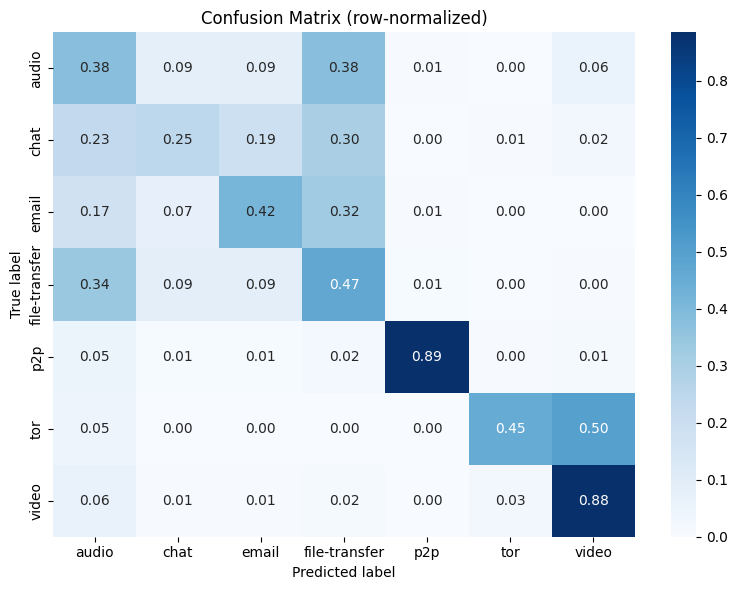

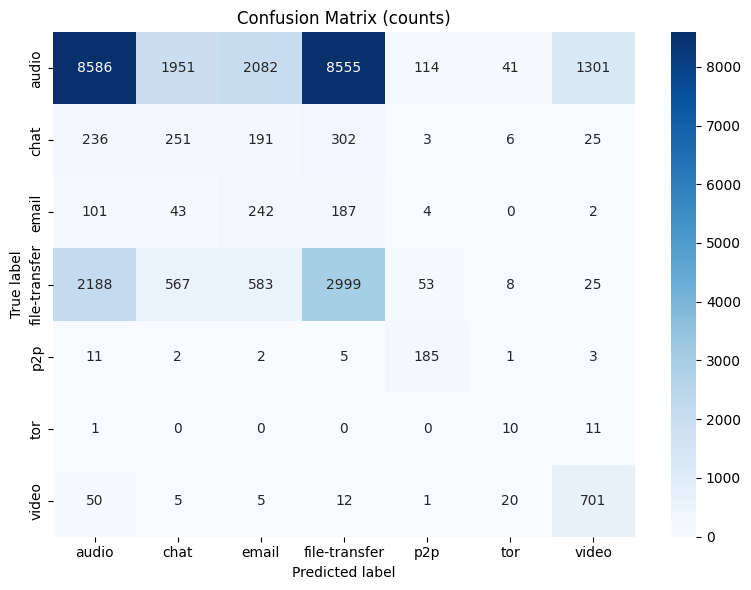


Top feature importances:
 1. size_min                        0.0862
 2. log_total_bytes                 0.0768
 3. total_bytes                     0.0727
 4. size_q10                        0.0601
 5. size_max                        0.0508
 6. size_q25                        0.0507
 7. prop_size_0_100                 0.0419
 8. iat_min                         0.0341
 9. iat_q10                         0.0228
10. duration                        0.0222
11. iat_q25                         0.0222
12. size_q90                        0.0222
13. size_median                     0.0219
14. log_duration                    0.0213
15. iat_q90                         0.0191
16. iat_q75                         0.0181
17. iat_mean                        0.0165
18. bytes_per_time                  0.0160
19. size_q75                        0.0158
20. iat_median                      0.0156


In [5]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
)

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# ---------------------------------------------------------
# 1. Prepare features and labels
# ---------------------------------------------------------

# Assume df already exists in memory
label_cols = ["easy_label", "medium_label", "hard_label"]
id_cols = ["sampleID"] if "sampleID" in df.columns else []
drop_cols = set(label_cols + id_cols)

feature_cols = [c for c in df.columns if c not in drop_cols]
target_col = "easy_label"   # 7-class label

X = df[feature_cols].values
y_raw = df[target_col].astype(str).values

# Encode labels to integers
le = LabelEncoder()
y = le.fit_transform(y_raw)
class_names = le.classes_

print("Number of samples:", X.shape[0])
print("Number of features:", X.shape[1])
print("Classes:", class_names)

# ---------------------------------------------------------
# 2. Train / test split (80/20, stratified)
# ---------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_SEED,
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

# ---------------------------------------------------------
# 3. Random Forest hyperparameter search (lighter + multi-core)
# ---------------------------------------------------------

# IMPORTANT: n_jobs=1 here so CV can parallelize across cores via RandomizedSearchCV
rf_base = RandomForestClassifier(
    n_estimators=300,
    n_jobs=1,
    random_state=RANDOM_SEED,
    class_weight="balanced_subsample",
)

# Trimmed, sane search space (you can expand later if needed)
param_dist = {
    "n_estimators": [200, 400, 600],          # no 800/1000 to start
    "max_depth": [None, 10, 20, 30],          # drop 40 for now
    "min_samples_split": [2, 5],              # fewer options
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", 0.3, 0.5],       # no 0.7/log2 for now
    "bootstrap": [True],                      # drop False (expensive)
}

rf_search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_dist,
    n_iter=12,               # small to start; can increase if needed
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,               # parallelize across folds/params
    verbose=2,
    random_state=RANDOM_SEED,
)

print("\n=== Starting RandomizedSearchCV (light config) ===")
rf_search.fit(X_train, y_train)

print("\nBest params:", rf_search.best_params_)
print("Best CV macro F1:", rf_search.best_score_)

rf_best = rf_search.best_estimator_

# ---------------------------------------------------------
# 4. Evaluation on held-out test set
# ---------------------------------------------------------

y_pred = rf_best.predict(X_test)
y_proba = rf_best.predict_proba(X_test)

# F1 scores
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_weighted = f1_score(y_test, y_pred, average="weighted")
f1_micro = f1_score(y_test, y_pred, average="micro")

print(f"\nTest F1 (macro):   {f1_macro:.4f}")
print(f"Test F1 (weighted): {f1_weighted:.4f}")
print(f"Test F1 (micro):    {f1_micro:.4f}")

# mAP (macro)
y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
mAP_macro = average_precision_score(y_test_bin, y_proba, average="macro")
print(f"Test mAP (macro):  {mAP_macro:.4f}")

print("\nClassification report (per class):")
print(classification_report(y_test, y_pred, target_names=class_names))

# ---------------------------------------------------------
# 5. Confusion matrix (normalized + counts)
# ---------------------------------------------------------

cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (row-normalized)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (counts)")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 6. Feature importance
# ---------------------------------------------------------

importances = rf_best.feature_importances_
indices = np.argsort(importances)[::-1]

top_k = 20
print("\nTop feature importances:")
for i in range(min(top_k, len(feature_cols))):
    idx = indices[i]
    print(f"{i+1:2d}. {feature_cols[idx]:30s}  {importances[idx]:.4f}")


In [ ]:
from sklearn.metrics import average_precision_score

# micro AP
map_micro = average_precision_score(y_test_bin, y_proba, average="micro")
print("Test mAP (micro):", map_micro)


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
)

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# ---------------------------------------------------------
# 1. Prepare features and labels for MEDIUM level
# ---------------------------------------------------------

# df is assumed to already include your engineered features
label_cols = ["easy_label", "medium_label", "hard_label"]
id_cols = ["sampleID"] if "sampleID" in df.columns else []
drop_cols = set(label_cols + id_cols)

feature_cols = [c for c in df.columns if c not in drop_cols]
target_col = "medium_label"   # 31-class label

X = df[feature_cols].values
y_raw = df[target_col].astype(str).values

# Encode labels
le_mid = LabelEncoder()
y = le_mid.fit_transform(y_raw)
class_names = le_mid.classes_

print("=== Medium-level task ===")
print("Number of samples:", X.shape[0])
print("Number of features:", X.shape[1])
print("Num classes:", len(class_names))
print("Classes:", class_names)

# ---------------------------------------------------------
# 2. Train / test split (80/20, stratified)
# ---------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_SEED,
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

# ---------------------------------------------------------
# 3. Random Forest hyperparameter search (medium level)
# ---------------------------------------------------------

# Start near the good region we found for easy_label, but keep it light
rf_base = RandomForestClassifier(
    n_estimators=300,
    n_jobs=1,                     # let RandomizedSearchCV parallelize
    random_state=RANDOM_SEED,
    class_weight="balanced_subsample",
)

param_dist_mid = {
    "n_estimators": [200, 400, 600],
    "max_depth": [20, 30, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", 0.3],
    "bootstrap": [True],
}

rf_search_mid = RandomizedSearchCV(
    rf_base,
    param_distributions=param_dist_mid,
    n_iter=12,               # can bump to 20 if still fast enough
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_SEED,
)

print("\n=== Starting RandomizedSearchCV for medium_label ===")
rf_search_mid.fit(X_train, y_train)

print("\nBest params (medium):", rf_search_mid.best_params_)
print("Best CV macro F1 (medium):", rf_search_mid.best_score_)

rf_best_mid = rf_search_mid.best_estimator_

# ---------------------------------------------------------
# 4. Evaluation on held-out test set (medium level)
# ---------------------------------------------------------

y_pred = rf_best_mid.predict(X_test)
y_proba = rf_best_mid.predict_proba(X_test)

# F1 scores
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_weighted = f1_score(y_test, y_pred, average="weighted")
f1_micro = f1_score(y_test, y_pred, average="micro")

print(f"\n[Medium] Test F1 (macro):   {f1_macro:.4f}")
print(f"[Medium] Test F1 (weighted): {f1_weighted:.4f}")
print(f"[Medium] Test F1 (micro):    {f1_micro:.4f}")

# mAP (macro)
y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
mAP_macro = average_precision_score(y_test_bin, y_proba, average="macro")
print(f"[Medium] Test mAP (macro):  {mAP_macro:.4f}")

print("\n[Medium] Classification report (per class):")
print(classification_report(y_test, y_pred, target_names=class_names))

# ---------------------------------------------------------
# 5. Confusion matrix (might be large: 31x31)
# ---------------------------------------------------------

cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_norm,
    annot=False,  # True will be tiny; turn on if you zoom
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (row-normalized) – medium_label")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 6. Feature importance for medium level
# ---------------------------------------------------------

importances = rf_best_mid.feature_importances_
indices = np.argsort(importances)[::-1]

top_k = 20
print("\n[Medium] Top feature importances:")
for i in range(min(top_k, len(feature_cols))):
    idx = indices[i]
    print(f"{i+1:2d}. {feature_cols[idx]:30s}  {importances[idx]:.4f}")


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
)

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# ---------------------------------------------------------
# 1. Prepare features and labels for HARD level
# ---------------------------------------------------------

# df is assumed to already include your engineered features
label_cols = ["easy_label", "medium_label", "hard_label"]
id_cols = ["sampleID"] if "sampleID" in df.columns else []
drop_cols = set(label_cols + id_cols)

feature_cols = [c for c in df.columns if c not in drop_cols]
target_col = "hard_label"   # fine-grained label

X = df[feature_cols].values
y_raw = df[target_col].astype(str).values

# Encode hard labels
le_hard = LabelEncoder()
y = le_hard.fit_transform(y_raw)
class_names = le_hard.classes_

print("=== Hard-level task ===")
print("Number of samples:", X.shape[0])
print("Number of features:", X.shape[1])
print("Num classes:", len(class_names))
print("Classes:", class_names)

# ---------------------------------------------------------
# 2. Train / test split (80/20, stratified)
# ---------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_SEED,
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

# ---------------------------------------------------------
# 3. Random Forest hyperparameter search (HARD level)
# ---------------------------------------------------------

# Hard level is very imbalanced; keep class_weight on
rf_base = RandomForestClassifier(
    n_estimators=300,
    n_jobs=1,                     # let RandomizedSearchCV parallelize
    random_state=RANDOM_SEED,
    class_weight="balanced_subsample",
)

param_dist_hard = {
    "n_estimators": [200, 400, 600],
    "max_depth": [20, 30, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", 0.3],
    "bootstrap": [True],
}

rf_search_hard = RandomizedSearchCV(
    rf_base,
    param_distributions=param_dist_hard,
    n_iter=12,               # bump to 20 if you want, once you see runtime
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_SEED,
)

print("\n=== Starting RandomizedSearchCV for hard_label ===")
rf_search_hard.fit(X_train, y_train)

print("\nBest params (hard):", rf_search_hard.best_params_)
print("Best CV macro F1 (hard):", rf_search_hard.best_score_)

rf_best_hard = rf_search_hard.best_estimator_

# ---------------------------------------------------------
# 4. Evaluation on held-out test set (hard level)
# ---------------------------------------------------------

y_pred = rf_best_hard.predict(X_test)
y_proba = rf_best_hard.predict_proba(X_test)

# F1 scores
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_weighted = f1_score(y_test, y_pred, average="weighted")
f1_micro = f1_score(y_test, y_pred, average="micro")

print(f"\n[Hard] Test F1 (macro):   {f1_macro:.4f}")
print(f"[Hard] Test F1 (weighted): {f1_weighted:.4f}")
print(f"[Hard] Test F1 (micro):    {f1_micro:.4f}")

# mAP (macro)
y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
mAP_macro = average_precision_score(y_test_bin, y_proba, average="macro")
print(f"[Hard] Test mAP (macro):  {mAP_macro:.4f}")

print("\n[Hard] Classification report (per class):")
print(classification_report(y_test, y_pred, target_names=class_names))

# ---------------------------------------------------------
# 5. Confusion matrix (can be big; you may want to subset to top classes)
# ---------------------------------------------------------

cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm_norm,
    annot=False,  # True gets unreadable with many classes
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (row-normalized) – hard_label")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 6. Feature importance for hard level
# ---------------------------------------------------------

importances = rf_best_hard.feature_importances_
indices = np.argsort(importances)[::-1]

top_k = 20
print("\n[Hard] Top feature importances:")
for i in range(min(top_k, len(feature_cols))):
    idx = indices[i]
    print(f"{i+1:2d}. {feature_cols[idx]:30s}  {importances[idx]:.4f}")


nPrint Method - potentially do later

In [ ]:
import pandas as pd
import pcapml_fe
from pathlib import Path

# Step 1: Extract flow-level labels with flow_id
flow_label_rows = []

for tsample in pcapml_fe.sampler(str(PCAP_PATH)):
    meta = str(tsample.metadata).strip()
    parts = meta.split("_")
    if len(parts) != 3:
        raise ValueError(f"Unexpected metadata format for sample {tsample.sid}: {meta}")
    easy_lbl, med_lbl, hard_lbl = parts
    
    flow_label_rows.append({
        "flow_id": str(tsample.sid),
        "easy_label": easy_lbl,
        "medium_label": med_lbl,
        "hard_label": hard_lbl,
    })

flow_labels_df = pd.DataFrame(flow_label_rows)
print("Flow labels shape:", flow_labels_df.shape)

# Step 2: Load all nprint CSVs
dfs = []
for csv_file in Path("nprint_outputs").glob("*.csv"):
    df = pd.read_csv(csv_file)
    stem = csv_file.stem  # e.g., "12962054460325634226_audio_facebook"
    flow_id = stem.split("_")[0]  # Take only the numeric ID
    df["flow_id"] = flow_id
    dfs.append(df)

nprint_df = pd.concat(dfs, ignore_index=True)
print("nPrint features shape:", nprint_df.shape)

# Step 3: Join features with labels
final_df = nprint_df.merge(flow_labels_df, on="flow_id", how="left")
print("Final shape:", final_df.shape)
print(final_df.head())

# Check for NaN labels
print("NaN labels:", final_df["easy_label"].isna().sum())

In [ ]:
# Step 0: Prepare features (run once)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, average_precision_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Drop non-feature columns
X = final_df.drop(columns=["flow_id", "easy_label", "medium_label", "hard_label", "src_ip"])

# Handle any remaining NaN in features
X = X.fillna(-1)

print("Features shape:", X.shape)

In [ ]:
# Step 1: Easy Label Classification

y_easy = final_df["easy_label"]

# Encode labels
le_easy = LabelEncoder()
y_easy_encoded = le_easy.fit_transform(y_easy)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_easy_encoded, test_size=0.2, random_state=42, stratify=y_easy_encoded
)

# Train Random Forest
rf_easy = RandomForestClassifier(
    max_depth=10,
    n_estimators=100,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_easy.fit(X_train, y_train)

# Predictions
y_pred_easy = rf_easy.predict(X_test)
y_proba_easy = rf_easy.predict_proba(X_test)

# Metrics
f1_easy = f1_score(y_test, y_pred_easy, average='weighted')
print(f"Easy Label - F1 Score (weighted): {f1_easy:.4f}")

# mAP (average precision per class, then mean)
map_easy = np.mean([
    average_precision_score((y_test == i).astype(int), y_proba_easy[:, i])
    for i in range(len(le_easy.classes_))
])
print(f"Easy Label - mAP: {map_easy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_easy, target_names=le_easy.classes_))

# Confusion matrix
cm_easy = confusion_matrix(y_test, y_pred_easy)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_easy, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_easy.classes_, yticklabels=le_easy.classes_)
plt.title('Easy Label - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [ ]:
# Step 2: Medium Label Classification

y_medium = final_df["medium_label"]

# Encode labels
le_medium = LabelEncoder()
y_medium_encoded = le_medium.fit_transform(y_medium)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_medium_encoded, test_size=0.2, random_state=42, stratify=y_medium_encoded
)

# Train Random Forest
rf_medium = RandomForestClassifier(
    max_depth=10,
    n_estimators=100,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_medium.fit(X_train, y_train)

# Predictions
y_pred_medium = rf_medium.predict(X_test)
y_proba_medium = rf_medium.predict_proba(X_test)

# Metrics
f1_medium = f1_score(y_test, y_pred_medium, average='weighted')
print(f"Medium Label - F1 Score (weighted): {f1_medium:.4f}")

# mAP
map_medium = np.mean([
    average_precision_score((y_test == i).astype(int), y_proba_medium[:, i])
    for i in range(len(le_medium.classes_))
])
print(f"Medium Label - mAP: {map_medium:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_medium, target_names=le_medium.classes_))

# Confusion matrix
cm_medium = confusion_matrix(y_test, y_pred_medium)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_medium, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_medium.classes_, yticklabels=le_medium.classes_)
plt.title('Medium Label - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Step 3: Hard Label Classification

y_hard = final_df["hard_label"]

# Encode labels
le_hard = LabelEncoder()
y_hard_encoded = le_hard.fit_transform(y_hard)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_hard_encoded, test_size=0.2, random_state=42, stratify=y_hard_encoded
)

# Train Random Forest
rf_hard = RandomForestClassifier(
    max_depth=10,
    n_estimators=100,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_hard.fit(X_train, y_train)

# Predictions
y_pred_hard = rf_hard.predict(X_test)
y_proba_hard = rf_hard.predict_proba(X_test)

# Metrics
f1_hard = f1_score(y_test, y_pred_hard, average='weighted')
print(f"Hard Label - F1 Score (weighted): {f1_hard:.4f}")

# mAP
map_hard = np.mean([
    average_precision_score((y_test == i).astype(int), y_proba_hard[:, i])
    for i in range(len(le_hard.classes_))
])
print(f"Hard Label - mAP: {map_hard:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_hard, target_names=le_hard.classes_))

# Confusion matrix
cm_hard = confusion_matrix(y_test, y_pred_hard)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_hard, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_hard.classes_, yticklabels=le_hard.classes_)
plt.title('Hard Label - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()